# AGAIN-VC

Сеть для клонирования голоса из мелспектрограммы в мелспектрограмму

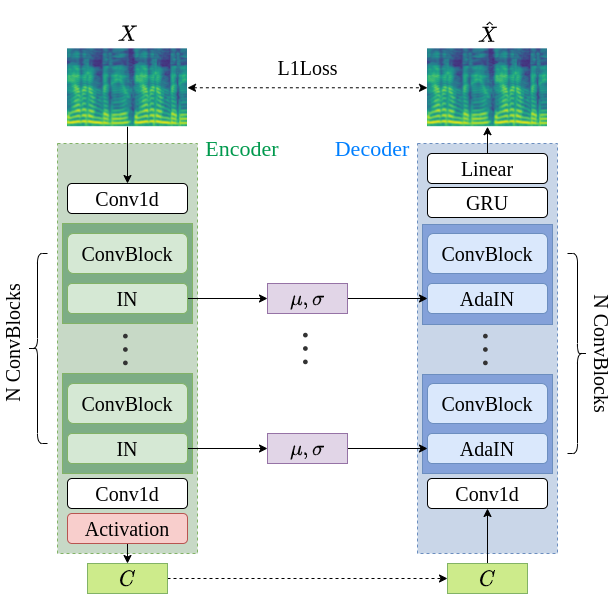

Предыдущие подходы подобных архитектур разделяли информацию о дикторе и сказанными им фразы на разные части сети, но информации просачивалось в чужой блок, что приводило к плохому качеству. Данный подход делает это одной сетью.

Архитектура похожа на Unet сеть и состоит из кодировщика и декодера. На каждом шаге выхода кодировщика вытаскивается информация о матожидании и дисперсии, содержащей информацию о дикторе, и передаётся в декодер.

Особенности AGAIN-VC:
1. Один кодировщик как для информации о дикторе, так и о контенте
2. Функция активации на выходе для усложнения

В качестве Вокодера я использовал свою реализацию MelGan




## Модель

In [ ]:
!git clone https://github.com/vlomme/AGAIN-MelGan-Voice-Cloning.git

In [ ]:
cd AGAIN-MelGan-Voice-Cloning/

In [ ]:
!gdown https://drive.google.com/uc?id=10tLduS5fGNWby7IKvfltuIfUWUeAp9SM
!unzip logs.zip

In [6]:
import IPython.display as ipd
import os,torch,librosa
import matplotlib.pyplot as plt
from utils import process_audio
from models import AgainModel,GeneratorMel
from hparams import Hparams
import librosa.display
import soundfile as sf

# Гиперпараметры
hp = Hparams()

# Устройство, видеокарта или процессор
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Создаём папку с выходными файлами
generate_dir = os.path.join(hp.generate_dir, 'output')    
os.makedirs(generate_dir, exist_ok=True)

# Создать модель
model = AgainModel().to(device)
model.eval()

# Загрузить чекпоинт
ckpt = torch.load(hp.again_checkpoint, map_location=device)
model.load_state_dict(ckpt['model'])

# Создаём вокодер и Загружаем веса
vocoder = GeneratorMel(hp.n_mels).to(device) 
ckpt = torch.load(hp.mel_checkpoint, map_location=device)
vocoder.load_state_dict(ckpt['G'])

# Загрузить звук
source = process_audio('gen/nada.wav', 'mel', wav_name=None, it_audio = False)[0]
target1 = process_audio('gen/o1.wav', 'mel', wav_name=None, it_audio = False)[0]
target2 = process_audio('gen/o2.wav', 'mel', wav_name=None, it_audio = False)[0]

# Получить новый путь   
source_path = os.path.join(generate_dir, 'nada')
target_path1 = os.path.basename('gen/o1.wav').replace('.wav','')
target_path2 = os.path.basename('gen/o2.wav').replace('.wav','')

# Получить новый файл
with torch.no_grad():    
    mel_output1 = model(source.unsqueeze(0).to(device), target1.unsqueeze(0).to(device)) 
    audio_output1 = vocoder(10**mel_output1).squeeze().cpu().numpy()
    sf.write(source_path+f'_to_{target_path1}'+'.wav', audio_output1, hp.sr)
    mel_output2 = model(source.unsqueeze(0).to(device), target2.unsqueeze(0).to(device)) 
    audio_output2 = vocoder(10**mel_output2).squeeze().cpu().numpy()
    sf.write(source_path+f'_to_{target_path2}'+'.wav', audio_output2, hp.sr)     

## Нарисовать Мелспектрограммы

In [ ]:
plt.figure(figsize=(16, 12))
ax = plt.subplot(3,1,1)
librosa.display.specshow(source.numpy(), cmap='viridis')
plt.title('Синтезированный оригинал + гриффин лимм')
plt.xlabel('')
plt.subplot(3,1,2, sharex=ax, sharey=ax)
librosa.display.specshow(mel_output1.squeeze().cpu().numpy(), cmap='viridis')
plt.title('Женский голос')
plt.xlabel('')
plt.subplot(3,1,3, sharex=ax, sharey=ax)
librosa.display.specshow(mel_output2.squeeze().cpu().numpy(), cmap='viridis')
plt.title('Мужской голос')
plt.xlabel('')
plt.tight_layout()
plt.show()

## Звук

In [ ]:
print("Оригинальная синтезированная запись")
ipd.display(ipd.Audio('gen/nada.wav',rate=16000))
print("Оригинальный мужской голос")
ipd.display(ipd.Audio('gen/o2.wav',rate=16000))
print("Клонированный мужской голос")
ipd.display(ipd.Audio('gen/output/nada_to_o2.wav',rate=16000))
print("Оригинальный женский голос")
ipd.display(ipd.Audio('gen/o1.wav',rate=16000))
print("Клонированный женский голос")
ipd.display(ipd.Audio('gen/output/nada_to_o1.wav',rate=16000))